# ACS2 in HandEye with Action Planning
In this notebook, I will show the results of using Action Planning in HandEye environment. You can read more about the use of the HandEye environment in [ACS2 in HandEye](ACS2 in HandEye.ipynb). Here I will focus only on the results.

I decided to not only see the results of just one experiment, but to see mean results of 100 experiments. It can be easily done, but of course will take a lot of time. For me, it took about 4 hours to run 100 experiments of HandEye3-v0 environment, 50 trials each. It will take of course more time for bigger environemnts (like HandEye5-v0 etc.), for more trials and for more experiments. The results are not, however, connected to time. I plotted all the results in a function of the number of trials. Time is irrelevant in this case. 

The results are easily read when they are in the form of a graph. Therefore, I used some functions to plot the numbers I get from running the experiments. They are of course mean values from all 100 experiments.

Let's start with dependencies and constants.

In [1]:
import datetime

import gym
import gym_handeye

from lcs.agents.acs2 import ACS2, ClassifiersList, Configuration
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from examples.acs2.handeye.utils import calculate_performance

TITLE_TEXT_SIZE=24
AXIS_TEXT_SIZE=18
LEGEND_TEXT_SIZE=16

Then I used some functions that are the same or similar to the ones from other Notebook - [ACS2 in HandEye](ACS2 in HandEye.ipynb). They might differ only because the ones here have an "additional_info" parameter.

In [2]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['steps'] = row['agent']['steps']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['knowledge'] = row['performance']['knowledge']
        row['with_block'] = row['performance']['with_block']
        row['no_block'] = row['performance']['no_block']
        return row

    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)

    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'

    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)

    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(
        lambda r: r['trial'] + len(explore_df), axis=1)

    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)

    return df


def plot_knowledge(df, ax=None, additional_info=""):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    explore_df['knowledge'].plot(ax=ax, c='blue')
    explore_df['with_block'].plot(ax=ax, c='green')
    explore_df['no_block'].plot(ax=ax, c='yellow')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Achieved knowledge{}".format(additional_info), fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Knowledge [%]", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylim([0, 105])
    ax.legend(fontsize=LEGEND_TEXT_SIZE)


def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()

    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")

    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')

    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')

    ax.set_title("Classifiers", fontsize=TITLE_TEXT_SIZE)
    ax.set_xlabel("Trial", fontsize=AXIS_TEXT_SIZE)
    ax.set_ylabel("Classifiers", fontsize=AXIS_TEXT_SIZE)
    ax.legend(fontsize=LEGEND_TEXT_SIZE)


def plot_performance(metrics_df, env_name, additional_info,
                     with_AP=""):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'ACS2 Performance in {env_name} environment '
                 f'{additional_info}', fontsize=32)

    ax2 = plt.subplot(211)
    plot_knowledge(metrics_df, ax2, with_AP)

    ax3 = plt.subplot(212)
    plot_classifiers(metrics_df, ax3)

    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)

Then, I had to write some functions to count the mean of all the values. I decided not to save all the results from all 100 experiments and then at the end count the mean, but to count it after each experiment.

It is counted basically as follows:

        mean = (a + b)/2
        mean = (mean * 2 + c)/3
        mean = (mean * 3 + d)/4
        
And so on.

In [3]:
def mean(i, row_mean, row, first, second):
    return (row_mean[first][second]
            * i + row[first][second]) / (i + 1)


def count_mean_values(i: int, metrics, mean_metrics):
    new_metrics = metrics.copy()
    for row, row_new, row_mean in zip(metrics, new_metrics, mean_metrics):
        row_new['performance']['knowledge'] = mean(i, row_mean, row,
                                                   'performance', 'knowledge')
        row_new['performance']['with_block'] = mean(i, row_mean, row,
                                                    'performance',
                                                    'with_block')
        row_new['performance']['no_block'] = mean(i, row_mean, row,
                                                  'performance', 'no_block')
        row_new['agent']['numerosity'] = mean(i, row_mean, row,
                                              'agent', 'numerosity')
        row_new['agent']['steps'] = mean(i, row_mean, row,
                                         'agent', 'steps')
        row_new['agent']['reliable'] = mean(i, row_mean, row,
                                            'agent', 'reliable')
    return new_metrics


def plot_handeye_mean(number_of_tests=50, env_name='HandEye3-v0',
                      filename='mean_results/handeye.pdf', do_action_planning=True,
                      number_of_trials_explore=50, number_of_trials_exploit=2):
    hand_eye = gym.make(env_name)
    cfg = Configuration(hand_eye.observation_space.n, hand_eye.action_space.n,
                        epsilon=1.0,
                        do_ga=False,
                        do_action_planning=do_action_planning,
                        performance_fcn=calculate_performance)

    mean_metrics_he_exploit = []
    mean_metrics_he_explore = []

    for i in range(number_of_tests):
        # explore
        agent_he = ACS2(cfg)
        population_he_explore, metrics_he_explore = agent_he.explore(
            hand_eye, number_of_trials_explore)

        # exploit
        agent_he = ACS2(cfg, population_he_explore)
        _, metrics_he_exploit = agent_he.exploit(hand_eye,
                                                 number_of_trials_exploit)

        mean_metrics_he_explore = count_mean_values(i, metrics_he_explore,
                                                    mean_metrics_he_explore)
        mean_metrics_he_exploit = count_mean_values(i, metrics_he_exploit,
                                                    mean_metrics_he_exploit)

    he_metrics_df = parse_metrics_to_df(mean_metrics_he_explore,
                                        mean_metrics_he_exploit)
    if do_action_planning:
        with_ap = ", with Action Planning"
    else:
        with_ap = ", without Action Planning"

    plot_performance(he_metrics_df, env_name,
                     '\nmean for {} experiments'.format(number_of_tests),
                     with_ap)
    plt.savefig(filename.replace(" ", "_"), format='pdf', dpi=100)
    return he_metrics_df

Then, I decided to put both results (with Action Planning and without Action Planning) in one pdf document, just so it'll be easily compared. Running all 100 experiments once again would be a waste of time (a lot of time, since it takes 4 hours), so I just use the already counted mean results.

In [4]:
def plot_both_performances(metrics_ap, metrics_no_ap, env_name,
                           additional_info):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle(f'ACS2 Performance in {env_name} environment '
                 f'{additional_info}', fontsize=32)

    ax2 = plt.subplot(211)
    plot_knowledge(metrics_ap, ax2, ", with Action Planning")

    ax3 = plt.subplot(212)
    plot_knowledge(metrics_no_ap, ax3, ", without Action Planning")

    plt.subplots_adjust(top=0.86, wspace=0.3, hspace=0.3)
    
def plot_with_without_ap(filename, metrics_ap, metrics_no_ap):
    plot_both_performances(metrics_ap, metrics_no_ap, env_name,
                           '\nmean for {} experiments'.format(number_of_tests))
    plt.savefig(filename.replace(" ", "_"), format='pdf', dpi=100)

Now, I was ready to run the experiments. Since it took 4 hours, I do not recommend running it when you don't have enough time. You can do a test with 2 experiments (less than 10 minutes), just as I did below. 

I print a timestamp and elapsed time just to know how much time it took, but it is not an important part of the experiment.

time start: 2018-10-03 11:05:45.593276
done with AP, time: 2018-10-03 11:10:17.738208, elapsed: 0:04:32.144932
done without AP, time: 2018-10-03 11:13:01.205566, elapsed: 0:02:43.467358


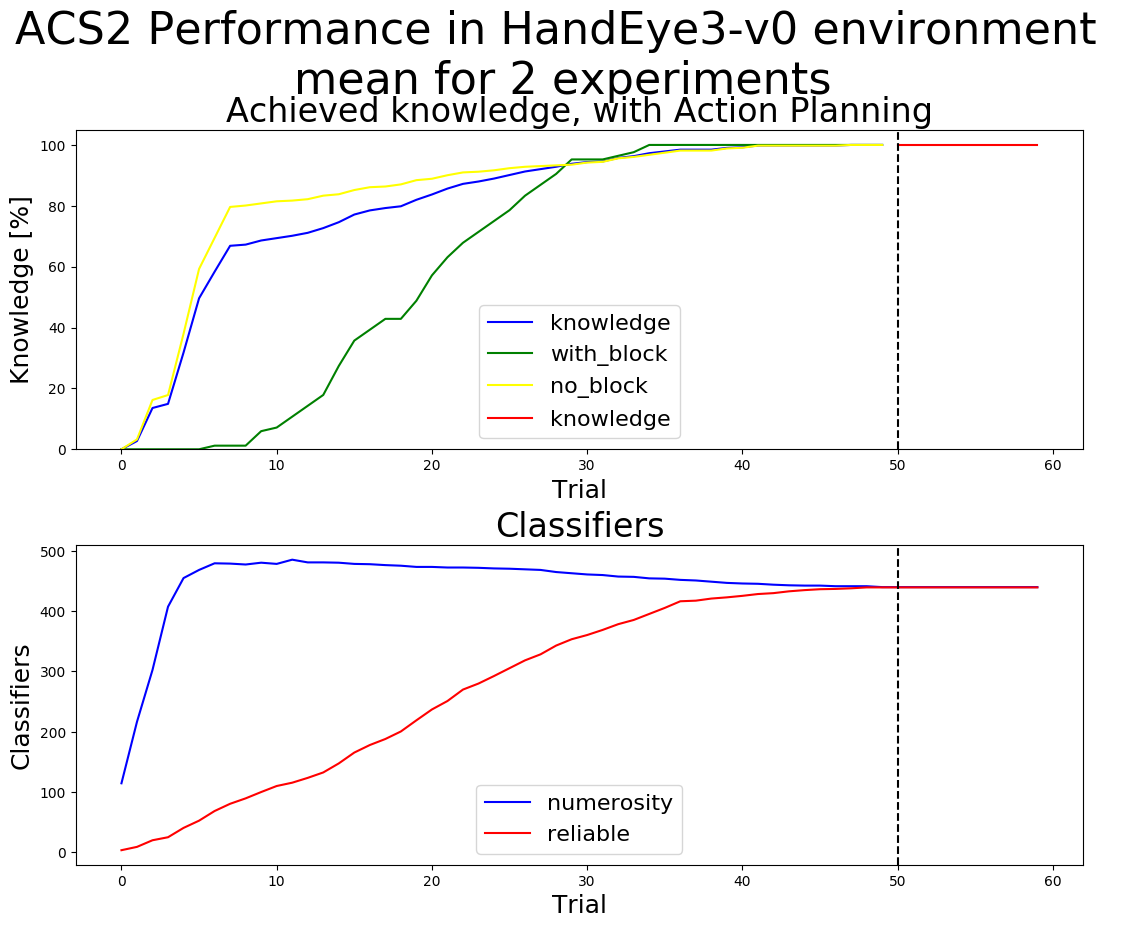

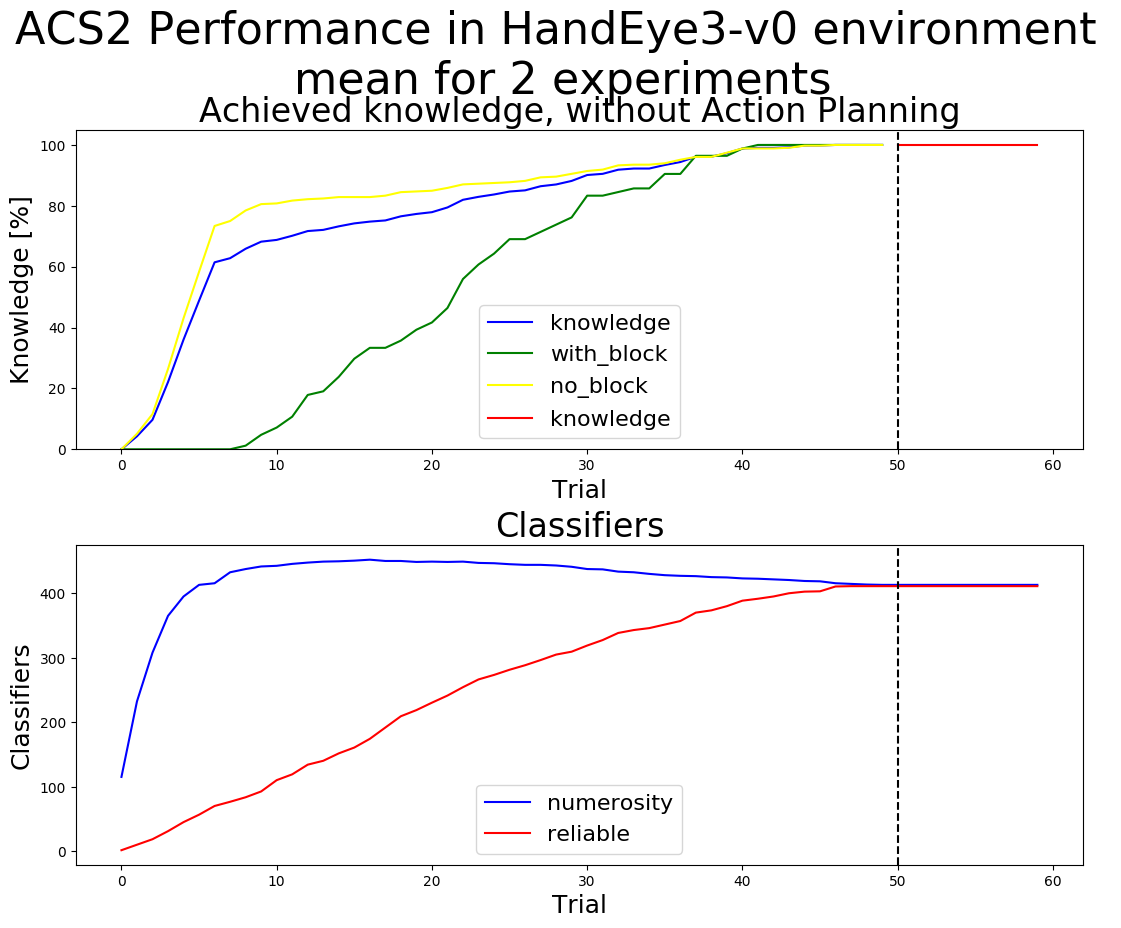

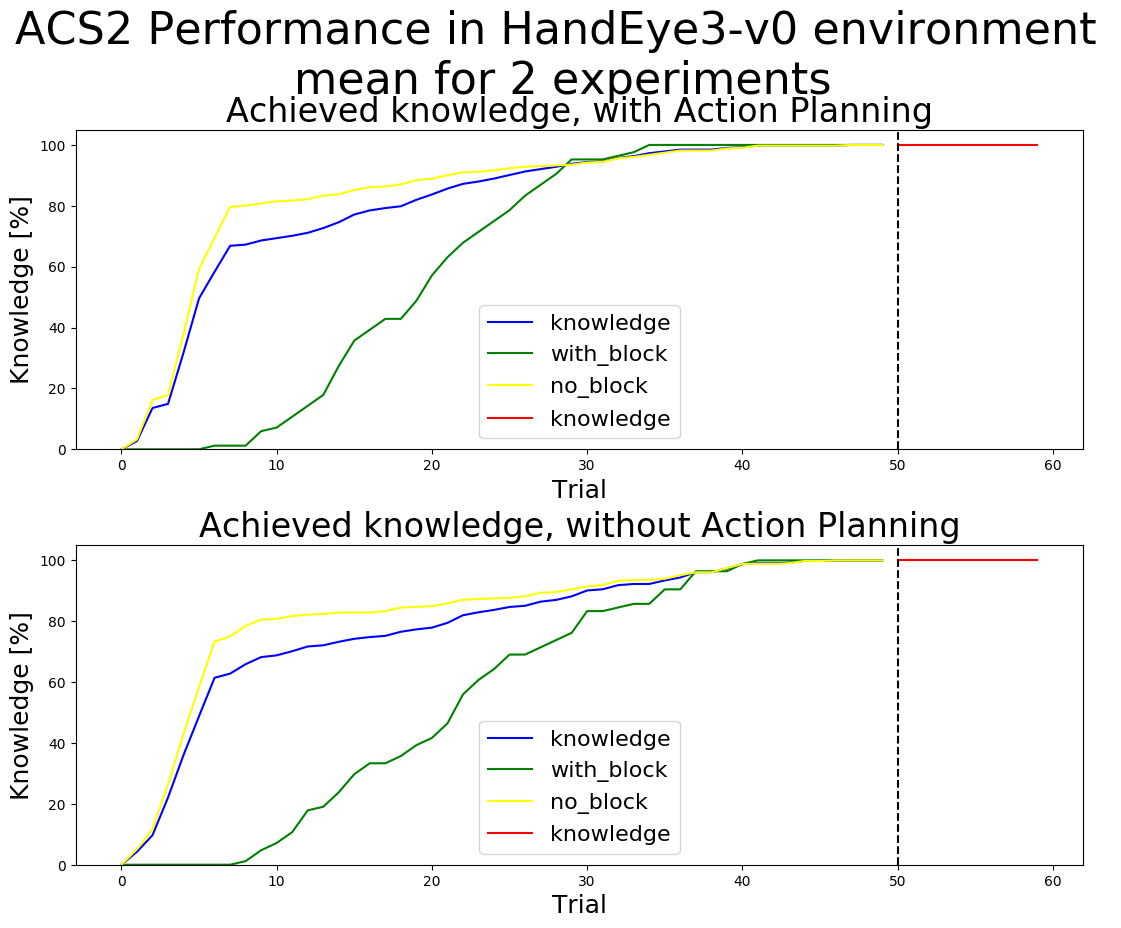

In [5]:
env_name = 'HandEye3-v0'
number_of_tests = 2
number_of_trials_explore = 50
number_of_trials_exploit = 10

start = datetime.datetime.now()
print("time start: {}".format(start))

metrics_ap = plot_handeye_mean(number_of_tests, env_name,
                               'mean_results/{}_ap_{}_{}.pdf'.
                               format(env_name, number_of_tests, start),
                               do_action_planning=True,
                               number_of_trials_explore=
                               number_of_trials_explore,
                               number_of_trials_exploit=
                               number_of_trials_exploit)

middle = datetime.datetime.now()
print("done with AP, time: {}, elapsed: {}".format(middle, middle-start))

metrics_no_ap = plot_handeye_mean(number_of_tests, env_name,
                                  'mean_results/{}_no_ap_{}_{}.pdf'.
                                  format(env_name, number_of_tests, start),
                                  do_action_planning=False,
                                  number_of_trials_explore=
                                  number_of_trials_explore,
                                  number_of_trials_exploit=
                                  number_of_trials_exploit)

end = datetime.datetime.now()
print("done without AP, time: {}, elapsed: {}".format(end, end-middle))

plot_with_without_ap('mean_results/{}_both_{}_{}.pdf'.format(env_name,
                                                      number_of_tests,
                                                      start),
                     metrics_ap, metrics_no_ap)

## 100 experiments results
For 100 experiment, the results are as shown below:

In [10]:
from IPython.display import IFrame
IFrame("mean_results/HandEye3-v0_both_100_2018-10-02_23:02:51.492298.pdf", width=800, height=600)

You can see that Action Planning makes gaining the knowledge, especially knowledge about transitions with block, a bit faster. It is as expected, although in the original article ("Action-Planning in Anticipatory Classifier System", Butz, Stolzmann) the results seem a little bit better (meaning faster when using Action Planning in comparison to not using it).

Overall, Action Planning makes gaining the knowledge in HandEye3 environment faster than when not using it. I think that the results for bigger environments could be even better, but it's yet to check.